In [113]:
import pandas as pd
from pathlib import Path

#FILE_PATH = Path("ITU_regional_global_Key_ICT_indicator_aggregates_Nov_2024.xlsx")
FILE_PATH = "/content/ITU_regional_global_Key_ICT_indicator_aggregates_Nov_2024.xlsx"
OUTPUT_DIR = Path("./output")
#OUTPUT_DIR = Path("/content/output")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def is_year(x):
    try:
        xi = int(float(x))
        return 1990 <= xi <= 2035
    except Exception:
        return False


def clean_number(v):
    if pd.isna(v):
        return None
    s = str(v).strip()
    if s == "" or s.upper() in {"N/A", "NA"}:
        return None
    s = s.replace(" ", "").replace(",", ".")
    try:
        return float(s)
    except Exception:
        return None


def read_sheet_drop_first_row(path: Path, sheet_name: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet_name, header=None, engine="openpyxl")
    if len(df) >= 1:
        df = df.iloc[1:].reset_index(drop=True)
    return df


def find_header_row_with_years(df: pd.DataFrame, start_row=0, max_scan=160) -> int | None:
    nrows = len(df)
    end_row = min(start_row + max_scan, nrows)
    for r in range(start_row, end_row):
        row_vals = df.iloc[r].tolist()
        if sum(1 for v in row_vals if is_year(v)) >= 3:
            return r
    return None


# ----------- Critères figés -----------

CRITERIA_BY_GENDER = [
    "Percentage of individuals using the Internet, by gender",
    "Percentage of individuals owning a mobile phone*, by gender",
]

CRITERIA_BY_AGE = [
    "Percentage of individuals using the Internet, by age",
]

CRITERIA_URBAN_RURAL = [
    "Population covered by a mobile-cellular network (%)",
    "Population covered by at least a 3G mobile network (%)",
    "Population covered by at least an LTE/WiMAX mobile network (%)",
    "Population covered by at least a 5G mobile network (%)",
    "Percentage of individuals using the Internet, by urban/rural area",
]

CRITERIA_BDT_REGION = [
    "Fixed-telephone subscriptions/Millions",
    "Fixed-broadband subscriptions/Millions",
    "Mobile-cellular telephone subscriptions/Millions",
    "Active mobile-broadband subscriptions/Millions",
    "Population covered by a mobile-cellular network/Millions",
    "Population covered by at least a 3G mobile network/Millions",
    "Population covered by at least an LTE/WiMAX mobile network/Millions",
    "Population covered by at least a 5G mobile network/Millions",
    "Fixed broadband traffic(Exabytes)",
    "Mobile broadband traffic(Exabytes)",
    "International bandwidth usage(Tbits/s**)",
    "Individuals using the Internet(Millions)",
    "Individuals owning a mobile phone***(Millions)",
]

CRITERIA_DVPMNT_SPEC = [
    "Fixed-telephone subscriptions",
    "Fixed-broadband subscriptions",
    "Mobile-cellular telephone subscriptions",
    "Active mobile-broadband subscriptions",
    "Population covered by a mobile-cellular network",
    "Population covered by at least a 3G mobile network",
    "Population covered by at least an LTE/WiMAX mobile network",
    "Population covered by at least a 5G mobile network",
    "Fixed broadband traffic",
    "Mobile broadband traffic",
    "International bandwidth usage",
    "Individuals using the Internet",
    "Individuals owning a mobile phone***",
]


# ----------- melt par segments de colonnes (catégorie au-dessus) -----------

def melt_block_with_column_categories(df: pd.DataFrame, header_row: int) -> pd.DataFrame:
    """
    Pour une ligne d'années header_row, trouve les segments contigus de colonnes d'années
    (Total, Female, Urban, etc.), lit la catégorie sur la ligne h-1 au-dessus de la
    première colonne de chaque segment, et renvoie un DataFrame concaténé:
    Region, Year, Value, Category.
    """
    nrows, ncols = df.shape
    # Colonnes d'années
    year_cols = [c for c, v in enumerate(df.iloc[header_row]) if is_year(v)]
    if not year_cols:
        return pd.DataFrame()

    # Regroupe les colonnes d'années en segments contigus
    segments = []
    start = year_cols[0]
    prev = start
    for c in year_cols[1:]:
        if c == prev + 1:
            prev = c
        else:
            segments.append((start, prev))
            start = c
            prev = c
    segments.append((start, prev))

    blocks = []
    data_start = header_row + 1

    for (c_start, c_end) in segments:
        # Catégorie : texte sur la ligne juste au-dessus de c_start
        cat = "Total"
        if header_row > 0:
            r_cat = header_row - 1
            val = df.iat[r_cat, c_start]
            if not (isinstance(val, str) and val.strip()) and c_start + 1 < ncols:
                # parfois le texte est dans la colonne juste à droite
                val2 = df.iat[r_cat, c_start + 1]
                if isinstance(val2, str) and val2.strip():
                    val = val2
            if isinstance(val, str) and val.strip():
                cat = val.strip()

        # Sous-DataFrame : Region + ce segment de colonnes d'années
        cols = [0] + list(range(c_start, c_end + 1))
        sub = df.iloc[data_start:, cols].copy()
        # Filtre les lignes vides côté Region
        sub = sub[
            ~sub.iloc[:, 0].isna()
            & (sub.iloc[:, 0].astype(str).str.strip() != "")
        ]
        if sub.empty:
            continue

        years = [
            int(float(df.iat[header_row, c])) for c in range(c_start, c_end + 1)
        ]
        sub.columns = ["Region"] + years
        melted = sub.melt(id_vars=["Region"], var_name="Year", value_name="Value")
        melted["Value"] = melted["Value"].map(clean_number)
        melted = melted.dropna(subset=["Value"])
        if melted.empty:
            continue
        melted["Category"] = cat
        blocks.append(melted)

    if not blocks:
        return pd.DataFrame()

    out = pd.concat(blocks, ignore_index=True)
    return out


# ----------- extraction séquentielle de headers -----------

def extract_blocks_sequentially(df: pd.DataFrame, max_headers: int):
    """
    Parcourt le DataFrame pour trouver des lignes d'années successives.
    Pour chaque ligne d'années, applique melt_block_with_column_categories.
    Retourne une liste de DataFrames (chaque DF contient déjà Category).
    """
    parts = []
    cursor = 0
    found = 0
    while found < max_headers:
        h = find_header_row_with_years(df, start_row=cursor, max_scan=200)
        if h is None:
            break
        block = melt_block_with_column_categories(df, h)
        if block.empty:
            cursor = h + 1
            continue
        parts.append(block)
        found += 1
        cursor = h + 5
    return parts


def assign_criteria_in_order(parts, criteria, headers_per_criterion=1):
    """
    Associe chaque critère à une ou plusieurs lignes d'années (headers).

    parts : liste de DataFrames retournés par extract_blocks_sequentially
            (chaque élément = toutes les catégories pour UN header_row).
    criteria : liste de critères pour la feuille.
    headers_per_criterion : nombre de lignes d'années par critère (souvent 1).
    """
    out_parts = []
    expected_headers = len(criteria) * headers_per_criterion
    use_parts = parts[:expected_headers]
    for i, block in enumerate(use_parts):
        crit_idx = i // headers_per_criterion
        b = block.copy()
        b["Criteria"] = criteria[crit_idx]
        out_parts.append(b)
    return out_parts


# ----------- Fonctions par feuille -----------

def extract_by_gender():
    xls = pd.ExcelFile(FILE_PATH)
    sheet = next((s for s in xls.sheet_names if "by gender" in s.lower()), None)
    if sheet is None:
        raise ValueError("Feuille 'By gender' introuvable")
    df = read_sheet_drop_first_row(FILE_PATH, sheet)

    # 2 critères (Internet, mobile phone). En pratique: 1 header par critère
    header_parts = extract_blocks_sequentially(df, max_headers=len(CRITERIA_BY_GENDER))
    parts = assign_criteria_in_order(header_parts, CRITERIA_BY_GENDER, headers_per_criterion=1)

    if not parts:
        raise ValueError("Aucun bloc reconnu dans 'By gender'")

    out = pd.concat(parts, ignore_index=True)[
        ["Region", "Year", "Category", "Value", "Criteria"]
    ]
    out.to_csv(OUTPUT_DIR / "gender_flat.csv", index=False)
    print("OK ->", OUTPUT_DIR / "gender_flat.csv")


def extract_by_age():
    xls = pd.ExcelFile(FILE_PATH)
    sheet = next((s for s in xls.sheet_names if "internet use by age" in s.lower()), None)
    if sheet is None:
        raise ValueError("Feuille 'Internet use by age' introuvable")
    df = read_sheet_drop_first_row(FILE_PATH, sheet)

    # 1 critère, 1 header
    header_parts = extract_blocks_sequentially(df, max_headers=1)
    parts = assign_criteria_in_order(header_parts, CRITERIA_BY_AGE, headers_per_criterion=1)

    if not parts:
        raise ValueError("Aucun bloc reconnu dans 'Internet use by age'")

    out = pd.concat(parts, ignore_index=True)[
        ["Region", "Year", "Category", "Value", "Criteria"]
    ]
    out.to_csv(OUTPUT_DIR / "age_flat.csv", index=False)
    print("OK ->", OUTPUT_DIR / "age_flat.csv")


def extract_by_urban_rural_area():
    xls = pd.ExcelFile(FILE_PATH)
    sheet = next((s for s in xls.sheet_names if "urban-rural" in s.lower()), None)
    if sheet is None:
        raise ValueError("Feuille 'By urban-rural area' introuvable")
    df = read_sheet_drop_first_row(FILE_PATH, sheet)

    # 5 critères, 1 header par critère
    header_parts = extract_blocks_sequentially(df, max_headers=len(CRITERIA_URBAN_RURAL))
    parts = assign_criteria_in_order(header_parts, CRITERIA_URBAN_RURAL, headers_per_criterion=1)

    if not parts:
        raise ValueError("Aucun bloc reconnu dans 'By urban-rural area'")

    out = pd.concat(parts, ignore_index=True)[
        ["Region", "Year", "Category", "Value", "Criteria"]
    ]
    out.to_csv(OUTPUT_DIR / "urban_rural_flat.csv", index=False)
    print("OK ->", OUTPUT_DIR / "urban_rural_flat.csv")


def extract_by_bdt_region():
    xls = pd.ExcelFile(FILE_PATH)
    sheet = next((s for s in xls.sheet_names if "bdt region" in s.lower()), None)
    if sheet is None:
        raise ValueError("Feuille 'By BDT region' introuvable")
    df = read_sheet_drop_first_row(FILE_PATH, sheet)

    # 13 critères, 1 header par critère
    header_parts = extract_blocks_sequentially(df, max_headers=len(CRITERIA_BDT_REGION))
    parts = assign_criteria_in_order(header_parts, CRITERIA_BDT_REGION, headers_per_criterion=1)

    if not parts:
        raise ValueError("Aucun bloc reconnu dans 'By BDT region'")

    out = pd.concat(parts, ignore_index=True)[
        ["Region", "Year", "Category", "Value", "Criteria"]
    ]
    out.to_csv(OUTPUT_DIR / "bdt_region_flat.csv", index=False)
    print("OK ->", OUTPUT_DIR / "bdt_region_flat.csv")


def extract_by_dvpmnt_status_and_spec_reg():
    xls = pd.ExcelFile(FILE_PATH)
    sheet = next(
        (s for s in xls.sheet_names if "dvpmnt status" in s.lower() or "spec. reg" in s.lower()),
        None,
    )
    if sheet is None:
        raise ValueError("Feuille 'By dvpmnt status and spec. reg.' introuvable")
    df = read_sheet_drop_first_row(FILE_PATH, sheet)

    # 13 critères, 1 header par critère
    header_parts = extract_blocks_sequentially(df, max_headers=len(CRITERIA_DVPMNT_SPEC))
    parts = assign_criteria_in_order(header_parts, CRITERIA_DVPMNT_SPEC, headers_per_criterion=1)

    if not parts:
        raise ValueError("Aucun bloc reconnu dans 'By dvpmnt status and spec. reg.'")

    out = pd.concat(parts, ignore_index=True)[
        ["Region", "Year", "Category", "Value", "Criteria"]
    ]
    out.to_csv(OUTPUT_DIR / "dvpmnt_status_spec_reg_flat.csv", index=False)
    print("OK ->", OUTPUT_DIR / "dvpmnt_status_spec_reg_flat.csv")


if __name__ == "__main__":
    extract_by_gender()
    extract_by_age()
    extract_by_urban_rural_area()
    extract_by_bdt_region()
    extract_by_dvpmnt_status_and_spec_reg()

OK -> output/gender_flat.csv
OK -> output/age_flat.csv
OK -> output/urban_rural_flat.csv
OK -> output/bdt_region_flat.csv
OK -> output/dvpmnt_status_spec_reg_flat.csv


In [114]:
df_gender = pd.read_csv(OUTPUT_DIR / "gender_flat.csv")
df_gender

,Region,Year,Category,Value,Criteria
0,World,2019,Total,52.9,"Percentage of individuals using the Internet, ..."
1,Low-income,2019,Total,17.2,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2019,Total,33.5,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2019,Total,64.5,"Percentage of individuals using the Internet, ..."
4,High-income,2019,Total,87.5,"Percentage of individuals using the Internet, ..."
...,...,...,...,...,...
635,Americas,2024,Total,85.5,Percentage of individuals owning a mobile phon...
636,Arab States,2024,Total,75.1,Percentage of individuals owning a mobile phon...
637,Asia-Pacific,2024,Total,67.5,Percentage of individuals owning a mobile phon...
638,CIS,2024,Total,92.6,Percentage of individuals owning a mobile phon...


In [115]:
df_age = pd.read_csv(OUTPUT_DIR/ "age_flat.csv")
df_age

,Region,Year,Category,Value,Criteria
0,World,2021,Total,61.7,"Percentage of individuals using the Internet, ..."
1,Low-income,2021,Total,20.9,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2021,Total,46.6,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2021,Total,74.1,"Percentage of individuals using the Internet, ..."
4,High-income,2021,Total,90.0,"Percentage of individuals using the Internet, ..."
...,...,...,...,...,...
163,Americas,2024,Rest of the population,85.1,"Percentage of individuals using the Internet, ..."
164,Arab States,2024,Rest of the population,66.7,"Percentage of individuals using the Internet, ..."
165,Asia-Pacific,2024,Rest of the population,63.5,"Percentage of individuals using the Internet, ..."
166,CIS,2024,Rest of the population,90.7,"Percentage of individuals using the Internet, ..."


In [116]:
df_urban_rural = pd.read_csv(r"output/urban_rural_flat.csv")
df_urban_rural

,Region,Year,Category,Value,Criteria
0,World,2015,Total,94.9,Population covered by a mobile-cellular networ...
1,Low-income,2015,Total,80.7,Population covered by a mobile-cellular networ...
2,Lower-middle-income,2015,Total,94.4,Population covered by a mobile-cellular networ...
3,Upper-middle-income,2015,Total,96.7,Population covered by a mobile-cellular networ...
4,High-income,2015,Total,98.5,Population covered by a mobile-cellular networ...
...,...,...,...,...,...
5955,Americas,2024,Rural,30.7,"Percentage of individuals using the Internet, ..."
5956,Arab States,2024,Rural,0.8,"Percentage of individuals using the Internet, ..."
5957,Asia-Pacific,2024,Rural,41.0,"Percentage of individuals using the Internet, ..."
5958,CIS,2024,Rural,0.0,"Percentage of individuals using the Internet, ..."


In [117]:
df_dvpmnt = pd.read_csv(r"output/dvpmnt_status_spec_reg_flat.csv")
df_dvpmnt

,Region,Year,Category,Value,Criteria
0,World,2005,Millions,1243.2,Fixed-telephone subscriptions
1,Least Developed Countries (LDCs),2005,Millions,6.4,Fixed-telephone subscriptions
2,World,2005,Millions,219.6,Fixed-telephone subscriptions
3,Least Developed Countries (LDCs),2005,Millions,0.0,Fixed-telephone subscriptions
4,World,2005,Millions,2205.3,Fixed-telephone subscriptions
...,...,...,...,...,...
14155,Upper-middle-income,2024,Total,84.2,Individuals owning a mobile phone***
14156,High-income,2024,Total,96.1,Individuals owning a mobile phone***
14157,Least Developed Countries (LDCs),2024,Total,62.8,Individuals owning a mobile phone***
14158,Land Locked Developing Countries (LLDCs),2024,Total,64.6,Individuals owning a mobile phone***


In [118]:
df_bdt = pd.read_csv(r"output/bdt_region_flat.csv")
df_bdt

,Region,Year,Category,Value,Criteria
0,Africa,2005,Millions,10.3,Fixed-telephone subscriptions/Millions
1,Americas,2005,Millions,290.9,Fixed-telephone subscriptions/Millions
2,Arab States,2005,Millions,29.6,Fixed-telephone subscriptions/Millions
3,Asia-Pacific,2005,Millions,559.1,Fixed-telephone subscriptions/Millions
4,CIS,2005,Millions,51.6,Fixed-telephone subscriptions/Millions
...,...,...,...,...,...
15269,Americas,2024,Total,88.8,Individuals owning a mobile phone***(Millions)
15270,Arab States,2024,Total,83.1,Individuals owning a mobile phone***(Millions)
15271,Asia-Pacific,2024,Total,76.9,Individuals owning a mobile phone***(Millions)
15272,CIS,2024,Total,94.4,Individuals owning a mobile phone***(Millions)


In [119]:
#OUTPUT_DIR = Path("/content/output")

df_age         = pd.read_csv(OUTPUT_DIR / "age_flat.csv")
df_urban_rural = pd.read_csv(OUTPUT_DIR / "urban_rural_flat.csv")
df_dvpmnt      = pd.read_csv(OUTPUT_DIR / "dvpmnt_status_spec_reg_flat.csv")
df_bdt         = pd.read_csv(OUTPUT_DIR / "bdt_region_flat.csv")
df_gender      = pd.read_csv(OUTPUT_DIR / "gender_flat.csv")

In [120]:
df_all = pd.concat(
    [df_gender, df_age, df_urban_rural, df_dvpmnt, df_bdt],
    axis=0,          # empiler les lignes
    ignore_index=True  # réindexer de 0 à n-1
)

In [121]:
df_all.to_csv("./output/all_data.csv", index=False)

In [122]:
df_all

,Region,Year,Category,Value,Criteria
0,World,2019,Total,52.9,"Percentage of individuals using the Internet, ..."
1,Low-income,2019,Total,17.2,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2019,Total,33.5,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2019,Total,64.5,"Percentage of individuals using the Internet, ..."
4,High-income,2019,Total,87.5,"Percentage of individuals using the Internet, ..."
...,...,...,...,...,...
36197,Americas,2024,Total,88.8,Individuals owning a mobile phone***(Millions)
36198,Arab States,2024,Total,83.1,Individuals owning a mobile phone***(Millions)
36199,Asia-Pacific,2024,Total,76.9,Individuals owning a mobile phone***(Millions)
36200,CIS,2024,Total,94.4,Individuals owning a mobile phone***(Millions)


In [123]:
df_all.duplicated().sum()


np.int64(1232)

In [124]:
df_all[df_all.duplicated()]


,Region,Year,Category,Value,Criteria
522,CIS,2020,Total,79.5,Percentage of individuals owning a mobile phon...
531,Small Island Developing States (SIDS),2020,Total,73.8,Percentage of individuals owning a mobile phon...
539,Americas,2021,Total,81.9,Percentage of individuals owning a mobile phon...
1453,Low-income,2015,Urban,13.4,Population covered by a mobile-cellular networ...
1484,High-income,2016,Urban,100.0,Population covered by a mobile-cellular networ...
...,...,...,...,...,...
35236,Individuals using the Internet(Millions),2023,Total,2023.0,Mobile broadband traffic(Exabytes)
35243,Individuals owning a mobile phone***(Millions),2023,Total,2023.0,Mobile broadband traffic(Exabytes)
35256,International bandwidth usage(Tbits/s**),2024,Total,2024.0,Mobile broadband traffic(Exabytes)
35262,Individuals using the Internet(Millions),2024,Total,2024.0,Mobile broadband traffic(Exabytes)


In [125]:
sorted(df_all["Region"].unique()[:50])

['Active mobile-broadband subscriptions/Millions',
 'Africa',
 'Americas',
 'Arab States',
 'Asia-Pacific',
 'CIS',
 'Europe',
 'Fixed broadband traffic(Exabytes)',
 'Fixed-broadband subscriptions/Millions',
 'High-income',
 'Individuals owning a mobile phone***(Millions)',
 'Individuals using the Internet(Millions)',
 'International bandwidth usage(Tbits/s**)',
 'Land Locked Developing Countries (LLDCs)',
 'Least Developed Countries (LDCs)',
 'Low-income',
 'Lower-middle-income',
 'Mobile broadband traffic(Exabytes)',
 'Mobile-cellular telephone subscriptions/Millions',
 'Population covered by a mobile-cellular network/Millions',
 'Population covered by at least a 3G mobile network/Millions',
 'Population covered by at least a 5G mobile network/Millions',
 'Population covered by at least an LTE/WiMAX mobile network/Millions',
 'Small Island Developing States (SIDS)',
 'Upper-middle-income',
 'World']

In [126]:
valid_regions = [
    # Régions ITU
    "Africa",
    "Americas",
    "Arab States",
    "Asia-Pacific",
    "CIS",
    "Europe",
    "World",

    # Groupes de revenus
    "High-income",
    "Low-income",
    "Lower-middle-income",
    "Upper-middle-income",

    # Groupes spéciaux
    "Least Developed Countries (LDCs)",
    "Land Locked Developing Countries (LLDCs)",
    "Small Island Developing States (SIDS)",
]
df_all = df_all[df_all["Region"].isin(valid_regions)].copy()


In [127]:
df_all.duplicated().sum()
df_all[df_all.duplicated()]


,Region,Year,Category,Value,Criteria
522,CIS,2020,Total,79.5,Percentage of individuals owning a mobile phon...
531,Small Island Developing States (SIDS),2020,Total,73.8,Percentage of individuals owning a mobile phon...
539,Americas,2021,Total,81.9,Percentage of individuals owning a mobile phon...
1453,Low-income,2015,Urban,13.4,Population covered by a mobile-cellular networ...
1484,High-income,2016,Urban,100.0,Population covered by a mobile-cellular networ...
...,...,...,...,...,...
27116,Africa,2015,Total,11.1,Mobile-cellular telephone subscriptions/Millions
28885,Africa,2015,Total,11.1,Active mobile-broadband subscriptions/Millions
30434,Africa,2015,Percentage,11.1,Population covered by a mobile-cellular networ...
31703,Africa,2015,Total,11.1,Population covered by at least a 3G mobile net...


In [128]:
df_all = df_all.drop_duplicates()
df_all

,Region,Year,Category,Value,Criteria
0,World,2019,Total,52.9,"Percentage of individuals using the Internet, ..."
1,Low-income,2019,Total,17.2,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2019,Total,33.5,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2019,Total,64.5,"Percentage of individuals using the Internet, ..."
4,High-income,2019,Total,87.5,"Percentage of individuals using the Internet, ..."
...,...,...,...,...,...
36197,Americas,2024,Total,88.8,Individuals owning a mobile phone***(Millions)
36198,Arab States,2024,Total,83.1,Individuals owning a mobile phone***(Millions)
36199,Asia-Pacific,2024,Total,76.9,Individuals owning a mobile phone***(Millions)
36200,CIS,2024,Total,94.4,Individuals owning a mobile phone***(Millions)


In [129]:
# On part de df_all créé plus haut dans le notebook
df = df_all.copy()

print("Dimensions de df_all :", df.shape)

# Infos générales : types, nb de valeurs non nulles
df.info()

# Aperçu statistique rapide (inclut les colonnes catégorielles)
df.describe(include="all").T


Dimensions de df_all : (32870, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 32870 entries, 0 to 36201
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Region    32870 non-null  object 
 1   Year      32870 non-null  int64  
 2   Category  32870 non-null  object 
 3   Value     32870 non-null  float64
 4   Criteria  32870 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Region,32870,14,Arab States,2571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,32870.0,NaN,NaN,NaN,2018.317098,4.790198,2005.0,2016.0,2020.0,2022.0,2024.0
Category,32870,14,Total,21907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,32870.0,NaN,NaN,NaN,443.120735,1014.376657,0.0,40.7,86.8,258.9,9144.2
Criteria,32870,34,Fixed-telephone subscriptions,2114,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# Détection des colonnes object qui ressemblent à des nombres
obj_cols = df.select_dtypes(include="object").columns

def looks_numeric(series, sample_frac=0.3):
    """Heuristique : % de valeurs convertibles en nombre dans un échantillon."""
    s = series.dropna()
    if s.empty:
        return False
    s_sample = s.sample(frac=min(sample_frac, 1.0), random_state=42)
    converted = pd.to_numeric(s_sample, errors="coerce")
    return converted.notna().mean() > 0.8  # >80% de valeurs convertibles

numeric_like_cols = [c for c in obj_cols if looks_numeric(df[c])]

print("Colonnes object converties en numériques :")
print(numeric_like_cols)

for col in numeric_like_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


Colonnes object converties en numériques :
[]


In [131]:
# Taux de valeurs manquantes par colonne
missing_ratio = df.isna().mean().sort_values(ascending=False)

print("Taux de valeurs manquantes (top 30 colonnes) :")
missing_ratio.head(30)


Taux de valeurs manquantes (top 30 colonnes) :


,0
Region,0.0
Year,0.0
Category,0.0
Value,0.0
Criteria,0.0


In [132]:
import numpy as np
# Colonnes 100% vides ou contenant uniquement des NaN
empty_cols = [
    c for c in df.columns
    if df[c].isna().all() or df[c].replace({None: np.nan}).isna().all()
]

print(f"Colonnes entièrement vides détectées ({len(empty_cols)}):")
print(empty_cols)


Colonnes entièrement vides détectées (0):
[]


In [133]:
df_imputed = df.copy()

num_cols = df_imputed.select_dtypes(include=["number"]).columns
cat_cols = df_imputed.select_dtypes(exclude=["number"]).columns

print("Nb de colonnes numériques :", len(num_cols))
print("Nb de colonnes catégorielles :", len(cat_cols))

# Colonnes pertinentes pour grouper (si elles existent dans le jeu)
group_candidates = ["Region", "Development status", "Year", "Sex", "Area"]
group_cols = [c for c in group_candidates if c in df_imputed.columns]

print("Colonnes utilisées pour l'imputation par groupe :", group_cols)

# Imputation numérique : médiane par groupe si possible, sinon médiane globale
if group_cols:
    df_imputed[num_cols] = (
        df_imputed
        .groupby(group_cols)[num_cols]
        .transform(lambda s: s.fillna(s.median()))
    )

# Il peut rester des NA si certains groupes sont trop petits
df_imputed[num_cols] = df_imputed[num_cols].fillna(df_imputed[num_cols].median())

##################
#choix le plus impactant à faire
# Imputation catégorielle : mode (valeur la plus fréquente) sinon "Unknown"
for col in cat_cols:
    mode = df_imputed[col].mode(dropna=True)
    fill_value = mode.iloc[0] if not mode.empty else "Unknown"
    df_imputed[col] = df_imputed[col].fillna(fill_value)

######################

# Vérif globale
print("Nombre total de valeurs manquantes après imputation :",
      df_imputed.isna().sum().sum())


Nb de colonnes numériques : 2
Nb de colonnes catégorielles : 3
Colonnes utilisées pour l'imputation par groupe : ['Region', 'Year']
Nombre total de valeurs manquantes après imputation : 0


In [134]:
df_clean = df_imputed.copy()

# S'assurer que les colonnes de type année sont bien en int
for candidate in ["Year", "year", "Année"]:
    if candidate in df_clean.columns:
        df_clean[candidate] = df_clean[candidate].astype("int32")

print("Forme finale de df_clean :", df_clean.shape)
df_clean.head()


Forme finale de df_clean : (32870, 5)


,Region,Year,Category,Value,Criteria
0,World,2019,Total,52.9,"Percentage of individuals using the Internet, ..."
1,Low-income,2019,Total,17.2,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2019,Total,33.5,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2019,Total,64.5,"Percentage of individuals using the Internet, ..."
4,High-income,2019,Total,87.5,"Percentage of individuals using the Internet, ..."


In [135]:
# Encodage des columns catégorielles (types object, category)
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()

print("Colonnes catégorielles encodées :")
print(cat_cols)

df_ml = pd.get_dummies(
    df_clean,
    columns=cat_cols,
    drop_first=True,
    dtype="int8"
)

print("Forme de df_ml (prête pour le ML) :", df_ml.shape)
df_ml.head()


Colonnes catégorielles encodées :
['Region', 'Category', 'Criteria']
Forme de df_ml (prête pour le ML) : (32870, 61)


,Year,Value,Region_Americas,Region_Arab States,Region_Asia-Pacific,Region_CIS,Region_Europe,Region_High-income,Region_Land Locked Developing Countries (LLDCs),Region_Least Developed Countries (LDCs),...,Criteria_Population covered by a mobile-cellular network/Millions,Criteria_Population covered by at least a 3G mobile network,Criteria_Population covered by at least a 3G mobile network (%),Criteria_Population covered by at least a 3G mobile network/Millions,Criteria_Population covered by at least a 5G mobile network,Criteria_Population covered by at least a 5G mobile network (%),Criteria_Population covered by at least a 5G mobile network/Millions,Criteria_Population covered by at least an LTE/WiMAX mobile network,Criteria_Population covered by at least an LTE/WiMAX mobile network (%),Criteria_Population covered by at least an LTE/WiMAX mobile network/Millions
0,2019,52.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019,17.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019,33.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,64.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019,87.5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# Sanity check :
na_ml = df_ml.isna().sum().sum()
print("Nombre de NA dans df_ml :", na_ml)

if na_ml == 0:
    print("✅ df_ml ne contient plus de valeurs manquantes.")

# Export final
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

df_clean.to_csv(OUTPUT_DIR / "all_data_clean.csv", index=False)
df_ml.to_parquet(OUTPUT_DIR / "all_data_ml.parquet", index=False)

print("Fichiers exportés dans :", OUTPUT_DIR.resolve())


Nombre de NA dans df_ml : 0
✅ df_ml ne contient plus de valeurs manquantes.
Fichiers exportés dans : /content/output


### Data Visualization And Pipeline

In [137]:
df_all = df

In [182]:
#we correct the outliers with a global mean value
#This proccess should be ran before the visulizations and the normalization after that.
def clean_outliers(df, threshold=99.99):
    # Compute mean of values below threshold
    mean_value = df.loc[df["Value"] < threshold, "Value"].mean()

    # Replace outliers with the mean
    df.loc[df["Value"] > threshold, "Value"] = mean_value

    return df  # optional, since df is modified in place
df_all = clean_outliers(df_all)





In [183]:
#Testing outliers detection
print(df_all["Value"].max())


99.9


In [184]:
#First visualization representing the global parameters
bar_2021_WORLD_TOTAL = df[(df["Region"] == "World") & (df["Year"] == 2021) & (df["Category"] == "Total" )]


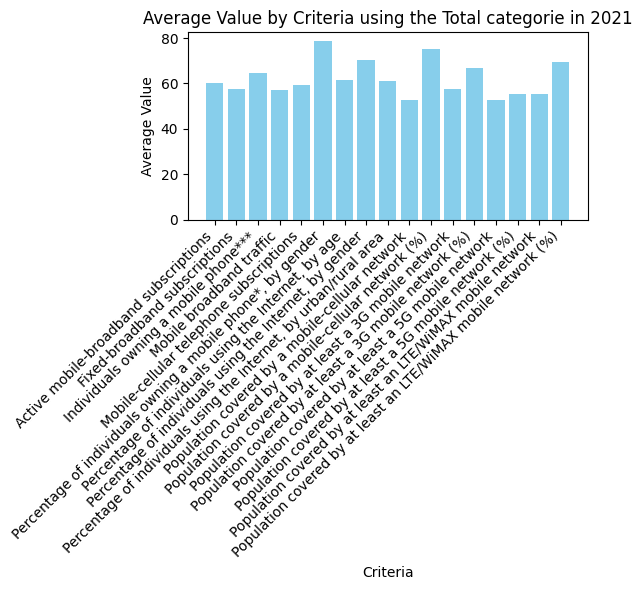

In [156]:
import matplotlib.pyplot as plt
df_grouped = bar_2021_WORLD_TOTAL.groupby("Criteria")["Value"].mean().reset_index()

labels = df_grouped["Criteria"]
values = df_grouped["Value"]

plt.figure(figsize=(6, 6))
plt.bar(labels ,values , color = "skyblue")
plt.xlabel("Criteria")
plt.ylabel("Average Value")
plt.title("Average Value by Criteria using the Total categorie in 2021")
plt.xticks(rotation=45, ha='right')  # Rotate labels if they are long
plt.tight_layout()  # Adjust layout so labels fit
plt.show()

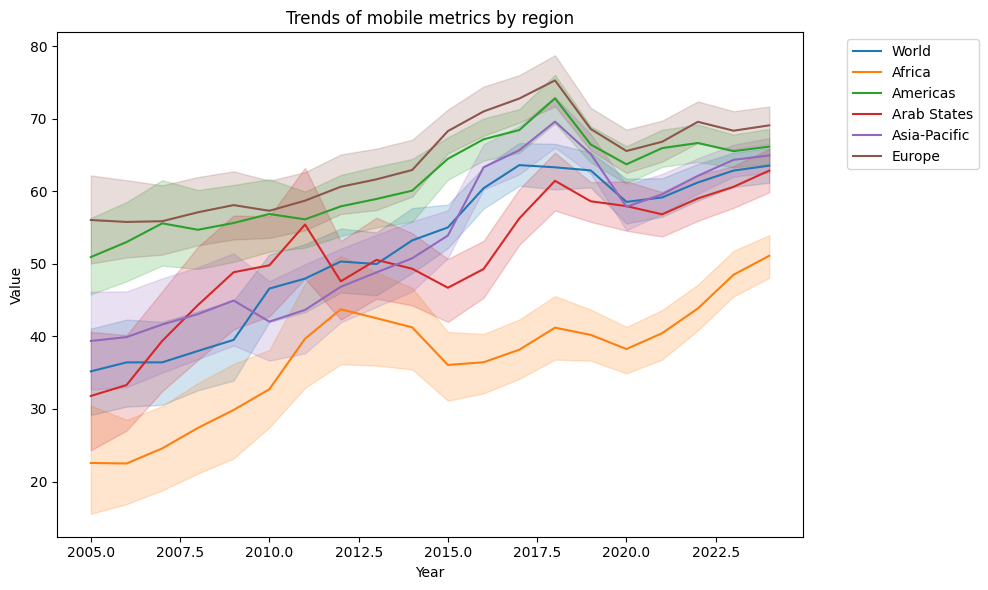

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
continents = ["Africa","Europe","Americas","Arab States","Asia-Pacific","World"]
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df[df["Region"].isin(continents)],
    x="Year", y="Value", hue="Region"
)
plt.title("Trends of mobile metrics by region")
plt.ylabel("Value")

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


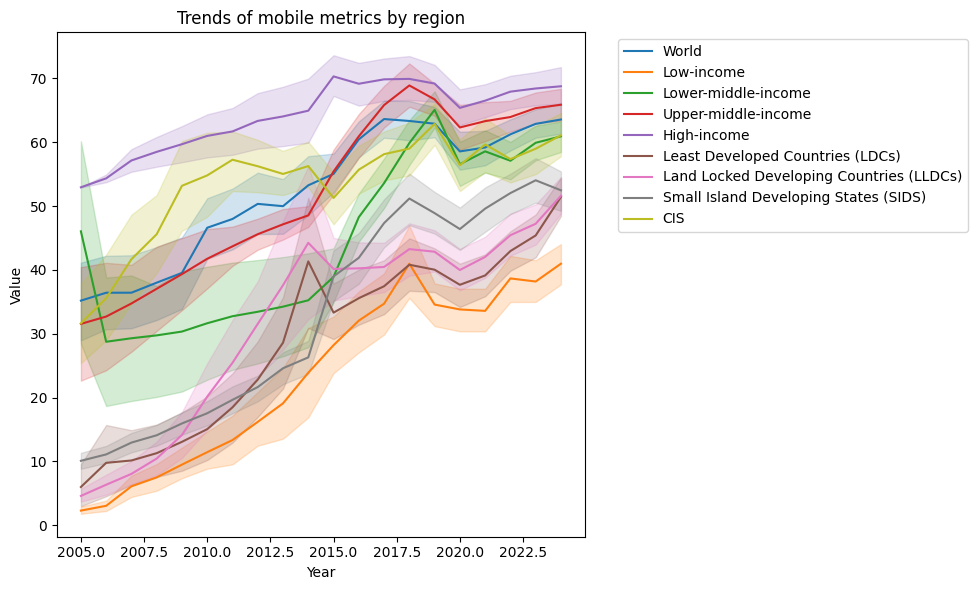

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
continents = ["Africa","Europe","Americas","Arab States","Asia-Pacific"]
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df[~df["Region"].isin(continents)],
    x="Year", y="Value", hue="Region"
)
plt.title("Trends of mobile metrics by region")
plt.ylabel("Value")

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

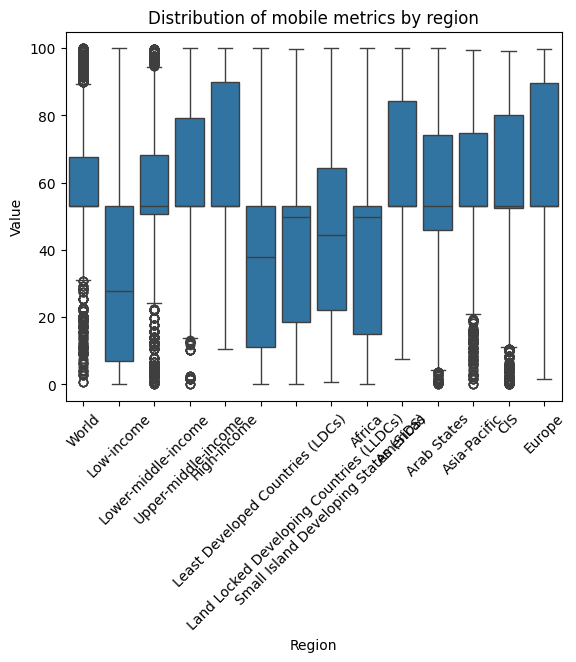

In [165]:
sns.boxplot(data=df[df["Region"].isin(valid_regions)], x="Region", y="Value")
plt.xticks(rotation=45)
plt.title("Distribution of mobile metrics by region")
plt.show()


/tmp/ipython-input-1370656498.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_2021_filtered, x="Region_num", y="Value", palette="tab10")


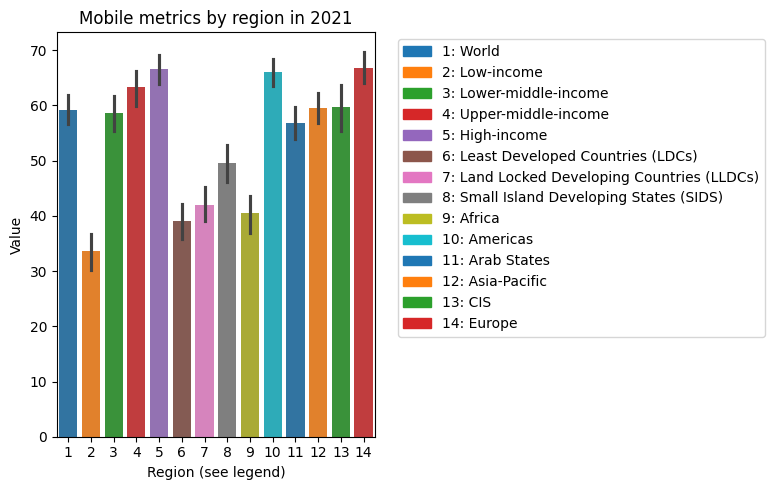

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data
df_2021_filtered = df_2021[df_2021["Region"].isin(valid_regions)].copy()

# Map each region to a number
region_mapping = {region: i+1 for i, region in enumerate(df_2021_filtered["Region"].unique())}
df_2021_filtered["Region_num"] = df_2021_filtered["Region"].map(region_mapping)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_2021_filtered, x="Region_num", y="Value", palette="tab10")

# Add title and labels
plt.xlabel("Region (see legend)")
plt.ylabel("Value")
plt.title("Mobile metrics by region in 2021")

# Create legend with numbers
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette("tab10")[i % 10])
           for i in range(len(region_mapping))]
labels = [f"{num}: {region}" for region, num in region_mapping.items()]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2406875112.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x="Criteria_num", y="Value", palette="tab10")


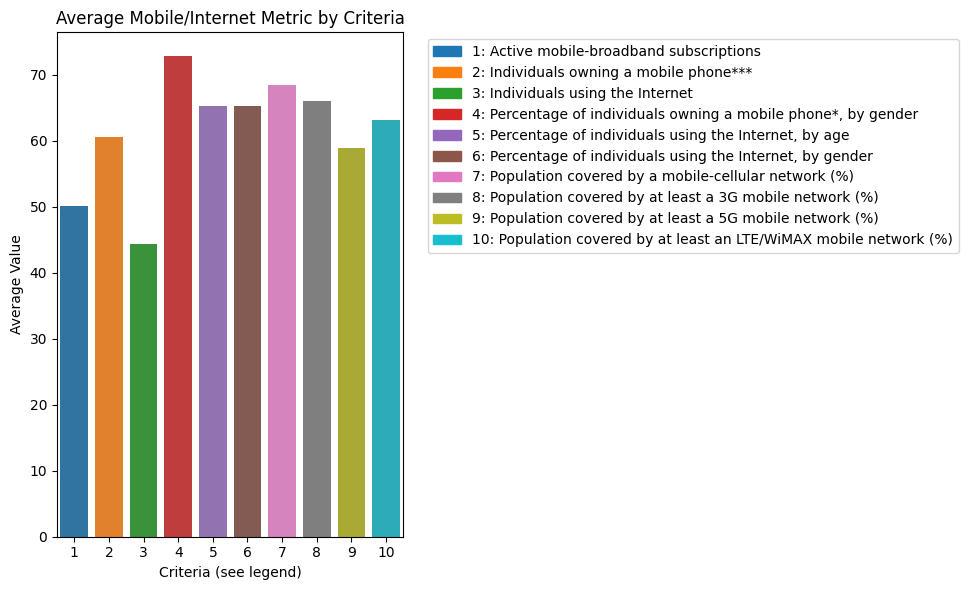

In [173]:
pertinent_criteria = [
    'Percentage of individuals using the Internet, by gender',
    'Percentage of individuals owning a mobile phone*, by gender',
    'Percentage of individuals using the Internet, by age',
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Active mobile-broadband subscriptions',
    'Individuals using the Internet',
    'Individuals owning a mobile phone***'
]
# Filter to pertinent criteria
df_filtered = df[df["Criteria"].isin(pertinent_criteria)].copy()

# Group by Criteria and take mean
df_grouped = df_filtered.groupby("Criteria")["Value"].mean().reset_index()

# Map criteria to numbers for x-axis
criteria_mapping = {crit: i+1 for i, crit in enumerate(df_grouped["Criteria"])}
df_grouped["Criteria_num"] = df_grouped["Criteria"].map(criteria_mapping)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_grouped, x="Criteria_num", y="Value", palette="tab10")

# Labels
plt.xlabel("Criteria (see legend)")
plt.ylabel("Average Value")
plt.title("Average Mobile/Internet Metric by Criteria")

# Legend
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette("tab10")[i % 10])
           for i in range(len(criteria_mapping))]
labels = [f"{num}: {crit}" for crit, num in criteria_mapping.items()]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Here below, we do not take gender or age into consideration, for the sake of global representation.

> Ajouter une citation



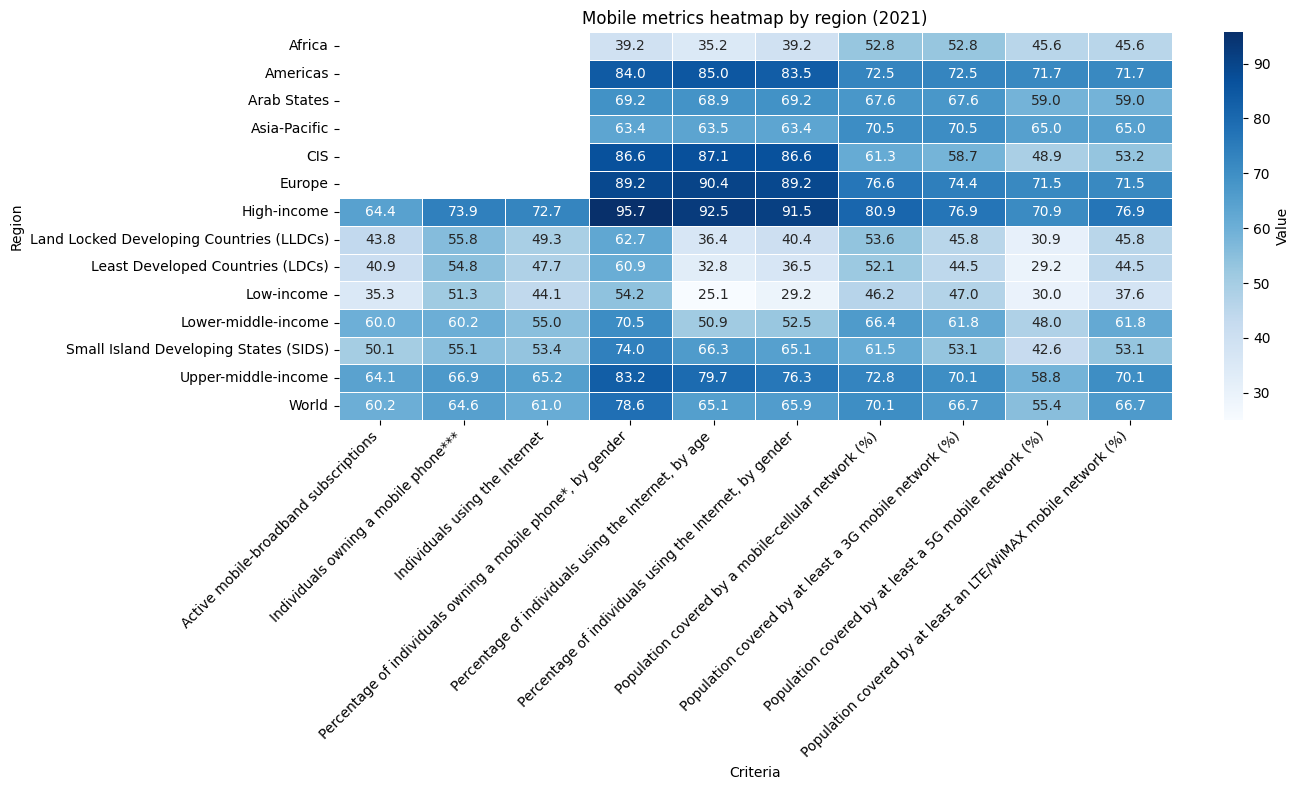

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to pertinent criteria
pertinent_criteria = [
    'Percentage of individuals using the Internet, by gender',
    'Percentage of individuals owning a mobile phone*, by gender',
    'Percentage of individuals using the Internet, by age',
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Active mobile-broadband subscriptions',
    'Individuals using the Internet',
    'Individuals owning a mobile phone***'
]

df_2021_filtered = df[(df["Year"]==2021) & (df["Criteria"].isin(pertinent_criteria))]

# Pivot
df_pivot = df_2021_filtered.pivot_table(index="Region", columns="Criteria", values="Value")

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(
    df_pivot,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Value'}
)

# Rotate x labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Mobile metrics heatmap by region (2021)")
plt.tight_layout()
plt.show()


In [180]:
from sklearn.preprocessing import StandardScaler

def normalize(df, column):
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df[[column]])
    return df





### Pipeline Implementation

In [189]:
def pipeline(df, column):
    df = clean_outliers(df)
    df = normalize(df, column)
    return df

clean_df  = pipeline(df_all,"Value")

clean_df

,Region,Year,Category,Value,Criteria
0,World,2019,Total,-0.004068,"Percentage of individuals using the Internet, ..."
1,Low-income,2019,Total,-1.357618,"Percentage of individuals using the Internet, ..."
2,Lower-middle-income,2019,Total,-0.739611,"Percentage of individuals using the Internet, ..."
3,Upper-middle-income,2019,Total,0.435741,"Percentage of individuals using the Internet, ..."
4,High-income,2019,Total,1.307776,"Percentage of individuals using the Internet, ..."
...,...,...,...,...,...
36197,Americas,2024,Total,1.357065,Individuals owning a mobile phone***(Millions)
36198,Arab States,2024,Total,1.140952,Individuals owning a mobile phone***(Millions)
36199,Asia-Pacific,2024,Total,0.905882,Individuals owning a mobile phone***(Millions)
36200,CIS,2024,Total,1.569387,Individuals owning a mobile phone***(Millions)
